In [1]:
import functions as f
import tokenizer_vars as tv

from Text import *
from LSTM_class import *
import constants as c

from keras import layers, models, optimizers, callbacks
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from transformers import BertTokenizer, GPT2Tokenizer
import pickle
import math

w:\anaconda3\envs\Viver\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
number_of_recipes = c.NUMBER_OF_RECIPES
tokenizer = tv.getTokenizer()

In [3]:
with open(f'data/pickle_files/indices_{number_of_recipes}.pkl', 'rb') as file:
    tokens_ind = pickle.load(file)

In [4]:
max_len = 15 #8
step = 14 #7
seq_train = Sequences(tokens_ind, max_len, step)
seq_train.sequences_info()

number of sequences of length 15: 48377


In [5]:
# print(input_train[:500])
# print(text_train.tokens[:50])
# print(text_train.tokens_ind[:50], '\n')

# np.array(seq_train.sequences[:2])

In [6]:
def lstm_model(sequence_length, vocab_size, layer_size):
    model = models.Sequential()
    input_sequence = layers.Input(shape=(sequence_length,))
    embedding = layers.Embedding(vocab_size, layer_size)(input_sequence)
    blstm = layers.Bidirectional(layers.LSTM(layer_size, return_sequences=True))(embedding)
    dropout = layers.Dropout(0.3)(blstm)
    lstm = layers.LSTM(layer_size)(dropout)
    attention = layers.Attention(layer_size)([lstm, lstm])
    concatenated = layers.Concatenate(axis=-1)([lstm, attention])
    dense = layers.Dense(vocab_size, activation='softmax')(concatenated)
    model = models.Model(inputs=input_sequence,outputs=dense)
    
    # model.add(layers.Embedding(vocab_size, layer_size))
    # model.add(layers.Bidirectional(layers.LSTM(layer_size, return_sequences=True)))
    # model.add(layers.Dropout(0.3))
    # model.add(layers.LSTM(layer_size))
    # model.add(layers.Dense(vocab_size, activation='softmax'))
    return model

In [7]:
tokenizer.get_vocab_size()

5013

In [8]:
batch_size_emb = 512 #1024

params_emb = {
    'sequence_length': max_len,
    'vocab_size': tokenizer.get_vocab_size(),
    'batch_size': batch_size_emb,
    'shuffle': True,
    'embedding': True
}

train_generator_emb = TextDataGenerator(seq_train.sequences, seq_train.next_words, **params_emb)

In [9]:
model_emb = lstm_model(max_len, len(tokenizer.get_vocab()), 512)
# optimizer = optimizers.RMSprop(lr=0.001)
optimizer = optimizers.Adam(learning_rate=0.01)
model_emb.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_emb.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 512)      2566656     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 15, 1024)     4198400     ['embedding[0][0]']              
                                                                                                  
 dropout (Dropout)              (None, 15, 1024)     0           ['bidirectional[0][0]']          
                                                                                              

In [10]:
early_stopping_callback = callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [11]:
history = model_emb.fit(
  train_generator_emb,
  steps_per_epoch=len(train_generator_emb),
  epochs=5,
  verbose=1,
  callbacks=[
      early_stopping_callback
  ]
)

Epoch 1/5


94/94 [==============================] - 94s 948ms/step - loss: 5.1807 - accuracy: 0.2012
Epoch 2/5
94/94 [==============================] - 84s 891ms/step - loss: 3.7899 - accuracy: 0.3680
Epoch 3/5
94/94 [==============================] - 82s 875ms/step - loss: 3.1046 - accuracy: 0.4549
Epoch 4/5
94/94 [==============================] - 67s 708ms/step - loss: 2.7678 - accuracy: 0.4899
Epoch 5/5
94/94 [==============================] - 67s 706ms/step - loss: 2.5621 - accuracy: 0.5087


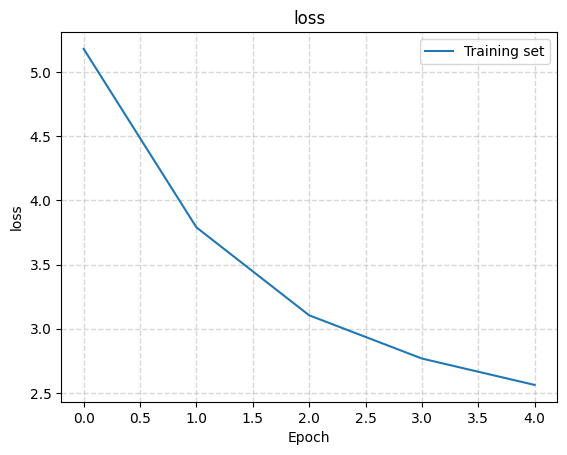

In [15]:
def render_training_history(training_history, metrics='loss'):
    metrics_history = training_history.history[metrics]

    plt.title(metrics)
    plt.xlabel('Epoch')
    plt.ylabel(metrics)
    plt.plot(metrics_history, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history, 'loss')

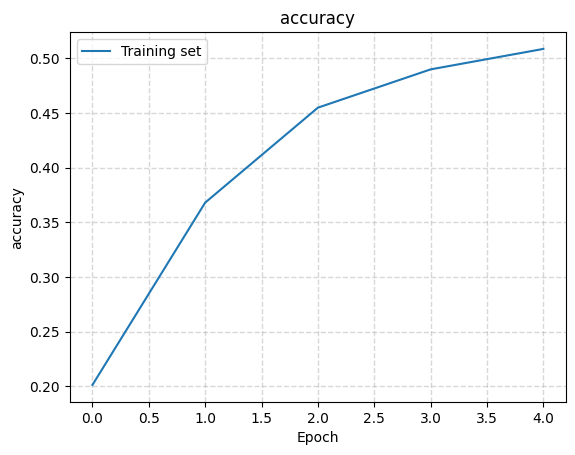

In [16]:
render_training_history(history, 'accuracy')

In [14]:
model_emb.save(f'data/out/blstm_model_{number_of_recipes}_emb_chef_tokenizer_long')

INFO:tensorflow:Assets written to: data/out/blstm_model_10000_emb_chef_tokenizer_long\assets


INFO:tensorflow:Assets written to: data/out/blstm_model_10000_emb_chef_tokenizer_long\assets
